In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
print(tf.__version__)

2.9.0


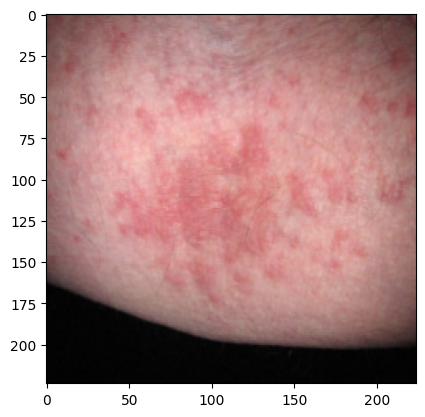

In [10]:
img=cv2.imread("../dataset/1. Eczema 1677/0_10.jpg")
img=cv2.resize(img,(224,224))
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [11]:
def preprocess (sdir, trsplit, vsplit):
    filepaths=[]
    labels=[]    
    classlist=os.listdir(sdir)
    for klass in classlist:
        classpath=os.path.join(sdir,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1)       
    # split df into train_df and test_df 
    dsplit=vsplit/(1-trsplit)
    strat=df['labels']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=strat)
    strat=dummy_df['labels']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
    print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
    print(train_df['labels'].value_counts())
    return train_df, test_df, valid_df

sdir=r'../dataset'
train_df, test_df, valid_df= preprocess(sdir, .9,.05)

train_df length:  24437   test_df length:  1358   valid_df length:  1358
labels
5. Melanocytic Nevi (NV) - 7970                                     7173
4. Basal Cell Carcinoma (BCC) 3323                                  2991
2. Melanoma 15.75k                                                  2826
10. Warts Molluscum and other Viral Infections - 2103               1893
6. Benign Keratosis-like Lesions (BKL) 2624                         1871
7. Psoriasis pictures Lichen Planus and related diseases - 2k       1849
8. Seborrheic Keratoses and other Benign Tumors - 1.8k              1662
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k    1532
1. Eczema 1677                                                      1509
3. Atopic Dermatitis - 1.25k                                        1131
Name: count, dtype: int64


In [12]:
train_df['labels'].value_counts()

labels
5. Melanocytic Nevi (NV) - 7970                                     7173
4. Basal Cell Carcinoma (BCC) 3323                                  2991
2. Melanoma 15.75k                                                  2826
10. Warts Molluscum and other Viral Infections - 2103               1893
6. Benign Keratosis-like Lesions (BKL) 2624                         1871
7. Psoriasis pictures Lichen Planus and related diseases - 2k       1849
8. Seborrheic Keratoses and other Benign Tumors - 1.8k              1662
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k    1532
1. Eczema 1677                                                      1509
3. Atopic Dermatitis - 1.25k                                        1131
Name: count, dtype: int64

In [13]:
size=1132
lst=list(np.unique(np.array(train_df['labels'])))
final_df=pd.DataFrame(columns=['filepaths','labels'])
for i in range(10):
    temp=train_df.loc[train_df['labels']==lst[i]]
    temp.reset_index()
    final_df=pd.concat([final_df,temp.iloc[:size]],axis=0)
final_df.reset_index()
final_df

,filepaths,labels
712,../dataset\1. Eczema 1677\t-eczema-lids-8.jpg,1. Eczema 1677
772,../dataset\1. Eczema 1677\t-eczema-nummular-17...,1. Eczema 1677
124,../dataset\1. Eczema 1677\4_12.jpg,1. Eczema 1677
1530,../dataset\1. Eczema 1677\v-eczema-nummular-84...,1. Eczema 1677
883,../dataset\1. Eczema 1677\t-eczema-subacute-68...,1. Eczema 1677
...,...,...
26939,../dataset\9. Tinea Ringworm Candidiasis and o...,9. Tinea Ringworm Candidiasis and other Fungal...
26768,../dataset\9. Tinea Ringworm Candidiasis and o...,9. Tinea Ringworm Candidiasis and other Fungal...
26483,../dataset\9. Tinea Ringworm Candidiasis and o...,9. Tinea Ringworm Candidiasis and other Fungal...
26148,../dataset\9. Tinea Ringworm Candidiasis and o...,9. Tinea Ringworm Candidiasis and other Fungal...


In [14]:
base_model=tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    input_shape=(224,224,3),
    weights='imagenet',
    classes=10
)
base_model.trainable=False

115263384/115263384 [==============================] - 357s 3us/step


In [15]:
for layer in base_model.layers[:-30]:
    layer.trainable=True

In [16]:
data_aug=tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
],name='Data_augmentation_layer')

In [17]:
inputs=tf.keras.Input(shape=(224,224,3),name="input_layer")
x=data_aug(inputs)
x=base_model(x)
x=tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=tf.keras.layers.Dense(256,activation='relu',kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),kernel_initializer=tf.keras.initializers.he_normal(),name='dense_layer2')(x)
x=tf.keras.layers.Dropout(0.5,seed=123)(x)
outputs=tf.keras.layers.Dense(10,activation='softmax',dtype=tf.float32)(x)

model=tf.keras.Model(inputs,outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision']
             )

In [18]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rescale=1./255
)

In [19]:
train_images = train_generator.flow_from_dataframe(
    final_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=32,
    seed=42
)
val_images = train_generator.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=16
)
test_images = test_generator.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    shuffle=True,
    class_mode='categorical',
    batch_size=10
)

Found 11319 validated image filenames belonging to 10 classes.
Found 1358 validated image filenames belonging to 10 classes.
Found 1358 validated image filenames belonging to 10 classes.


In [23]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='skin_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [22]:
!pip install pydot graphviz

     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     -------- ------------------------------- 10.2/47.0 kB ? eta -:--:--
     ------------------------ ------------- 30.7/47.0 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 391.5 kB/s eta 0:00:00


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dense_layer2 (Dense)        (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [ ]:
model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
 96/354 [=======>......................] - ETA: 29:39 - loss: 5.9770 - accuracy: 0.3460 - precision: 0.6692

In [ ]:
model.predict('../dataset/t\1. Eczema 1677/0_0.jpg')